# m6A peaks and AD GWAS signals

- Data: we have m6A peaks (bed-file like) from different tissues, as well as a version merging all tissues. We also have multiple AD GWAS summary stats from different AD studies where we know the z-score for each variant we analyze, as well as if a variant is in 95% CS from fine-mapping.


## Overall
In this notebook, I aim to map m6A peaks to our finemapped AD variants to explore potential enrichment of m6A peaks. The steps are as follows:

1.	Organize m6A peak data, including:
- Conversion from hg19 to hg38 (not shown in this notebook)
- Check m6A peak sizes and downsize those larger than 1kb
- Annotate each peak with a possible associated gene
2.	Load AD finemapped data and Bellenguez sumstats to use as background.
3.	Map m6A peaks to AD finemapped and non-AD finemapped data.
4.	Perform enrichment analysis based on different contexts in Step 3.
5.	Compare whether this enrichment is brain-specific by examining the number of regions with or without AD variants in brain tissue compared to other tissues.

all GWAS analysis are focusing on Bellenguze in notebook

In [80]:
library(tidyverse)
library(data.table)
library(bedtoolsr)
library(GenomicRanges)


## Organize m6A data

combine m6A region file from all contexts together

In [7]:
# file_name <- '~/data/m6A/hg38_convert/GSE114150_Brain_hg19Tohg38.bed'
m6a = data.frame()
for(file_name in list.files('~/data/m6A/hg38_convert/', 'bed$',full.names = T)){
    m6a_tmp <- fread(file_name) %>% mutate(hg38_ID = paste(V1,V2,V3, sep = ":"), context = basename(file_name) %>% gsub('_hg19Tohg38.bed','',.))
    m6a <- rbind(m6a, m6a_tmp)
}


### Check the size of m6A peaks. If the peak is > 1 Kb, take the center and extend 500 bp on each side.

In [8]:
m6a <- m6a %>% mutate(distance = V3-V2, 
               center = as.integer((V2+V3)/2),
               start = ifelse(distance <= 1000, V2, center - 500), 
               end = ifelse(distance <= 1000, V3, center + 500)) 
m6a %>% fwrite(., '~/data/m6A/hg38_convert/GSE114150_hg19Tohg38.all.modifyregion.bed.gz', sep = '\t')

combined 2 batches of peak data

In [73]:
m6a1 <- fread('~/data/m6A/hg38_convert/GSE114150_hg19Tohg38.all.modifyregion.bed.gz')
m6a2 <- fread('~/data/m6A/Liu2020_m6A/m6A_adult_hg19Tohg38.all.modifyregion.bed.gz')
m6a <- rbind(m6a1, m6a2, fill=T)

Add gene information into each peak. 
For the peak region we can keep every gene overlapped with it , and for the regions not covered with any gene body we pick the one with nearest TSS to center of m6A region

In [77]:
gene_region <- fread('~/data/ref_data_Ru/gene_region.tsv')

gene_region <- gene_region %>%
  mutate(gene_name = str_extract(V9, 'gene_name.*?;'), 
         gene_name = str_replace_all(gene_name, 'gene_name\\s*""?|""|;', ""),
        TSS = ifelse(V7 == "+", V4, V5))

In [78]:
# we only kept protein coding gene here
pro_gene_region <- gene_region %>% filter(str_detect(V9, "protein_coding")) 

colnames(pro_gene_region)[1] <- 'V1'
pro_gene_region %>% dim


[1] 19933    12

In [79]:
m6a %>% dim
m6a %>% head

[1] 452080     10

V1,V2,V3,V4,hg38_ID,context,distance,center,start,end
<chr>,<int>,<int>,<chr>,<chr>,<chr>,<int>,<int>,<int>,<int>
chr1,788796,789694,1:724176:725074,chr1:788796:789694,GSE114150_Brain,898,789245,788796,789694
chr1,789859,790063,1:725239:725443,chr1:789859:790063,GSE114150_Brain,204,789961,789859,790063
chr1,790159,790277,1:725539:725657,chr1:790159:790277,GSE114150_Brain,118,790218,790159,790277
chr1,790486,790653,1:725866:726033,chr1:790486:790653,GSE114150_Brain,167,790569,790486,790653
chr1,791162,791412,1:726542:726792,chr1:791162:791412,GSE114150_Brain,250,791287,791162,791412
chr1,818005,818185,1:753385:753565,chr1:818005:818185,GSE114150_Brain,180,818095,818005,818185


### Overlap the m6A peaks and gene region annotation file

In [81]:
# Load necessary libraries

# Convert m6a peaks data and gene region data (pro_gene_region) to GRanges objects
m6a_gr <- GRanges(
  seqnames = m6a$V1,
  ranges = IRanges(start = m6a$start, end = m6a$end)
)

gene_gr <- GRanges(
  seqnames = pro_gene_region$V1,
  ranges = IRanges(start = pro_gene_region$V4, end = pro_gene_region$V5),
  gene_id = pro_gene_region$gene,
  gene_name = pro_gene_region$gene_name
)

For the peak region we can keep every gene overlapped with it 

In [82]:
# Find overlaps between m6a data and gene regions
overlaps <- findOverlaps(m6a_gr, gene_gr)

# Extract overlapping rows and annotate with gene information
m6a_with_gene <- m6a[queryHits(overlaps), ]
m6a_with_gene$gene_id <- pro_gene_region$gene[subjectHits(overlaps)]
m6a_with_gene$gene_name <- pro_gene_region$gene_name[subjectHits(overlaps)]

# For non-overlapping rows, find the nearest TSS
non_overlapping_indices <- setdiff(seq_len(nrow(m6a)), queryHits(overlaps))
m6a_no_gene <- m6a[non_overlapping_indices, ]

Warning message in .merge_two_Seqinfo_objects(x, y):
“Each of the 2 combined objects has sequence levels not in the other:
  - in 'x': chrM
  - in 'y': chrMT
  Make sure to always combine/compare objects based on the same reference
  genome (use suppressWarnings() to suppress this warning).”


for the regions not covered with any gene body we pick the one with nearest TSS to center of m6A region

In [83]:
# Convert non-overlapping data to GRanges object using the center column
m6a_center_gr <- GRanges(
  seqnames = m6a_no_gene$V1,
  ranges = IRanges(start = m6a_no_gene$center, end = m6a_no_gene$center),  # Use the center column
  strand = m6a_no_gene$strand
)

# Create a GRanges object for gene data using the TSS as the start and end coordinates
gene_tss_gr <- GRanges(
  seqnames = pro_gene_region$V1,
  ranges = IRanges(start = pro_gene_region$TSS, end = pro_gene_region$TSS),  # TSS is used for both start and end
  strand = pro_gene_region$V7,
  gene_id = pro_gene_region$gene,
  gene_name = pro_gene_region$gene_name
)

# Find the nearest TSS for m6A peaks using the center
nearest_tss_indices <- nearest(m6a_center_gr, gene_tss_gr)

Warning message in .merge_two_Seqinfo_objects(x, y):
“Each of the 2 combined objects has sequence levels not in the other:
  - in 'x': chrM
  - in 'y': chrMT
  Make sure to always combine/compare objects based on the same reference
  genome (use suppressWarnings() to suppress this warning).”


combine above together

In [84]:
# Add nearest gene info to non-overlapping peaks
m6a_no_gene$gene_id <- gene_tss_gr$gene_id[nearest_tss_indices]
m6a_no_gene$gene_name <- gene_tss_gr$gene_name[nearest_tss_indices]

# Combine overlapping and non-overlapping data
m6a_gene_anno <- bind_rows(m6a_with_gene, m6a_no_gene)

# Check dimensions and preview data
m6a_no_gene %>% dim()
m6a_gene_anno %>% head()

[1] 71397    12

V1,V2,V3,V4,hg38_ID,context,distance,center,start,end,gene_id,gene_name
<chr>,<int>,<int>,<chr>,<chr>,<chr>,<int>,<int>,<int>,<int>,<chr>,<chr>
chr1,958977,959238,1:894357:894618,chr1:958977:959238,GSE114150_Brain,261,959107,958977,959238,ENSG00000188976,NOC2L
chr1,1027235,1027730,1:962615:963110,chr1:1027235:1027730,GSE114150_Brain,495,1027482,1027235,1027730,ENSG00000188157,AGRN
chr1,1034120,1034622,1:969500:970002,chr1:1034120:1034622,GSE114150_Brain,502,1034371,1034120,1034622,ENSG00000188157,AGRN
chr1,1043431,1043633,1:978811:979013,chr1:1043431:1043633,GSE114150_Brain,202,1043532,1043431,1043633,ENSG00000188157,AGRN
chr1,1054842,1055887,1:990222:991267,chr1:1054842:1055887,GSE114150_Brain,1045,1055364,1054864,1055864,ENSG00000188157,AGRN
chr1,1082006,1082102,1:1017386:1017482,chr1:1082006:1082102,GSE114150_Brain,96,1082054,1082006,1082102,ENSG00000131591,C1orf159


In [85]:
1 - (m6a_no_gene %>% distinct(hg38_ID, context) %>% nrow) / (m6a_gene_anno %>% distinct(hg38_ID, context) %>% nrow)

[1] 0.84207

 >85% peaks can be overlapped with gene body

## Load AD GWAS finemapping data
We focused on `AD_Bellenguez_2022` data and the variants in `cs_coverage_0.95_min_corr`

In [86]:
gwas <- fread('/mnt/vast/hpc/csg/rf2872/Work/Multivariate/GWAS_finemapping_Apr9/GWAS_finemapping_Apr9.union_export.tsv.gz')

gwas %>% dim
gwas <- gwas %>% 
        filter(study == 'AD_Bellenguez_2022') %>% 
        mutate(chr = str_split(variant_id, ":", simplify = T) %>% .[,1] %>% paste0("chr",.),
                pos = str_split(variant_id, ":", simplify = T) %>% .[,2] %>% as.numeric) %>% filter(cs_coverage_0.95_min_corr > 0)
gwas %>% head(n = 2)
gwas %>% dim

[1] 66479    15

variant_id,z,pip,cs_coverage_0.95,cs_coverage_0.7,cs_coverage_0.5,cs_coverage_0.95_min_corr,cs_coverage_0.7_min_corr,cs_coverage_0.5_min_corr,cs_coverage_0.95_attainable,cs_coverage_0.7_attainable,cs_coverage_0.5_attainable,study,method,block,chr,pos
<chr>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<dbl>
10:11676714:A:G,6.975610,0.979216533,1,1,1,1,1,1,1,1,1,AD_Bellenguez_2022,RSS_QC_RAISS_imputed,chr10_10500888_12817813,chr10,11676714
10:58094891:A:C,3.678899,0.001395639,1,0,0,1,0,0,NA,NA,NA,AD_Bellenguez_2022,RSS_QC_RAISS_imputed,chr10_57667362_59558848,chr10,58094891


[1] 1284   17

## Map m6A peaks to AD finemapped variants

In [87]:
m6a_gene_anno_bed <- m6a_gene_anno[, c("V1", "start", "end", "hg38_ID", "context", "gene_id", "gene_name")]
gwas_bed <- gwas[, .(chr, start_variant = as.integer(pos), end_variant = as.integer(pos), variant_id,z,pip,cs_coverage_0.95_min_corr,block, study)]

m6a_gene_bed_ad <- bt.intersect(a = m6a_gene_anno_bed, b = gwas_bed, wa = T, wb = T) 

In [88]:
colnames(m6a_gene_bed_ad) <- c("chrom", "start", "end", "hg38_ID", "context", "gene_id", "gene_name", colnames(gwas_bed))
m6a_gene_bed_ad %>% dim
m6a_gene_bed_ad %>% head

[1] 186  16

,chrom,start,end,hg38_ID,context,gene_id,gene_name,chr,start_variant,end_variant,variant_id,z,pip,cs_coverage_0.95_min_corr,block,study
,<chr>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<chr>,<dbl>,<dbl>,<int>,<chr>,<chr>
1,chr12,113158551,113159178,chr12:113158551:113159178,GSE114150_Brain,ENSG00000186710,CFAP73,chr12,113159061,113159061,12:113159061:G:A,4.575949,0.006127578,1,chr12_112825713_115165608,AD_Bellenguez_2022
2,chr12,113158551,113159178,chr12:113158551:113159178,GSE114150_Brain,ENSG00000123064,DDX54,chr12,113159061,113159061,12:113159061:G:A,4.575949,0.006127578,1,chr12_112825713_115165608,AD_Bellenguez_2022
3,chr12,113161821,113162088,chr12:113161821:113162088,GSE114150_Brain,ENSG00000123064,DDX54,chr12,113162061,113162061,12:113162061:T:C,4.490323,0.004234860,1,chr12_112825713_115165608,AD_Bellenguez_2022
4,chr12,113162795,113163180,chr12:113162795:113163180,GSE114150_Brain,ENSG00000123064,DDX54,chr12,113163098,113163098,12:113163098:A:G,4.483871,0.004119767,1,chr12_112825713_115165608,AD_Bellenguez_2022
5,chr12,113162795,113163180,chr12:113162795:113163180,GSE114150_Brain,ENSG00000123064,DDX54,chr12,113163135,113163135,12:113163135:C:T,4.518987,0.004788665,1,chr12_112825713_115165608,AD_Bellenguez_2022
6,chr12,113191735,113192015,chr12:113191735:113192015,GSE114150_Brain,ENSG00000139405,RITA1,chr12,113191832,113191832,12:113191832:G:A,4.449367,0.003557680,1,chr12_112825713_115165608,AD_Bellenguez_2022


The reginos numbers can have AD signals in each context are like below

In [89]:
m6a_gene_bed_ad %>% distinct(variant_id,context,hg38_ID, .keep_all = T) %>% pull(context) %>% table

.
        cerebellum           cerebrum    GSE114150_Brain    GSE114150_Heart 
                 2                  2                 18                 16 
  GSE114150_Kidney    GSE114150_Liver     GSE114150_Lung   GSE114150_merged 
                26                 11                  8                 30 
  GSE114150_Muscle GSE114150_Placenta  GSE114150_Stomach 
                14                 19                 10 

In [90]:
fwrite(m6a_gene_bed_ad, "GSE114150_Liu_Bellenguez_ADGWAS_cs95_mincorr_1kb.overlap.tsv", sep = '\t')

## Results for the comparison of annotated m6A peaks

### Figure 1: The consistency among different context/tissue
Define AD variants as variants in 95% CS from any AD GWAS data, we annotate these variants to see how many are m6A peaks. We see that brain m6A annotates more variants than other data-sets. Notice that this is variant level summary not CS level --- you can imagine limitations summarizing it this way, and how this can be improved to loci level summary if needed. I did not push it because I dont think we will use the UpsetR plot anyways, and I will get loci level information in the FET section i suggested.

cerebellum           cerebrum    GSE114150_Brain    GSE114150_Heart 
                 2                  2                 18                 16 
  GSE114150_Kidney    GSE114150_Liver     GSE114150_Lung   GSE114150_merged 
                26                 11                  8                 30 
  GSE114150_Muscle GSE114150_Placenta  GSE114150_Stomach 
                14                 19                 10

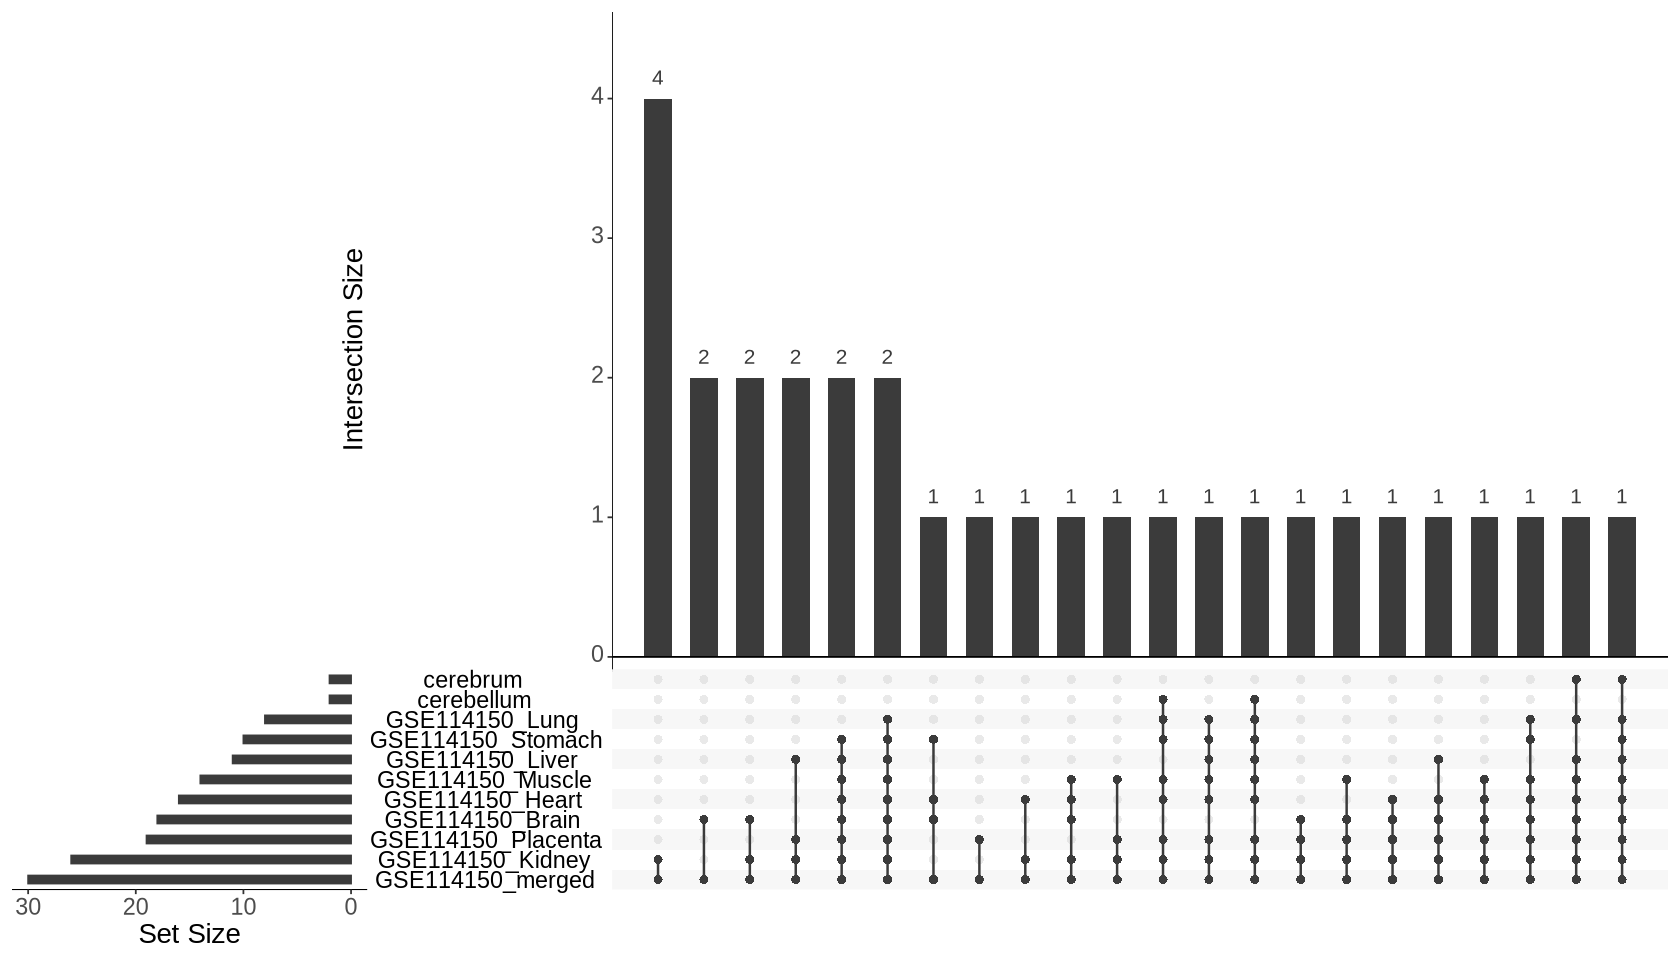

In [91]:
library(UpSetR)
library(tidyr)
library(dplyr)

options(repr.plot.width=14, repr.plot.height=8)
upset_data <- m6a_gene_bed_ad %>%
  select(variant_id, context) %>%
  distinct() %>%
  mutate(present = 1) %>%
  spread(key = context, value = present, fill = 0)
upset_data[,-1]%>% colSums
# Plot the UpSet plot to show how many variants are shared by contexts
upset(upset_data, sets = colnames(upset_data)[-1], order.by = "freq", text.scale = 2)

### Figure 2: Summarize the proportion of AD risk variants covered by peaks for each context and chromosome
Given a CS contain m6A peaks, we want to see what's the proportion of variants in the CS are m6A peaks. It's like how "pure" or "enriched" a CS is in terms of m6A modification. The goal here is to rule out if we have a very large CS with just one or two variants being m6A sites. And also to see if the overlap is not cluttered on a certain chromosome with large CS --- these are not clear from upsetR plot. Since we condition on CS containing m6A peak this is a relative metric and explains why brain has move CS+m6A overlaps than kidney but within those that are overlap, they behave similar. As I said I think this figure is more of a diagnosis although it does complement Figure 1 to further suggest that brain is interesting.

In [92]:
# Create a contingency table for intersected_data by context and chr
m6a_gene_bed_ad_table <- table(m6a_gene_bed_ad$context, m6a_gene_bed_ad$chrom)

# Create a table of gwas_bed counts by chromosome
gwas_chr_table <- table(gwas_bed$chr)

# Subset gwas_chr_table for chromosomes in intersected_table and repeat rows to match contexts
gwas_chr_counts <- gwas_chr_table[match(colnames(m6a_gene_bed_ad_table), names(gwas_chr_table))]

# Create a matrix where each row corresponds to a context and contains the chr counts from gwas_bed
gwas_chr_matrix <- matrix(gwas_chr_counts, nrow = nrow(m6a_gene_bed_ad_table), ncol = length(gwas_chr_counts), byrow = TRUE)

# Normalize the intersected_table by the corresponding gwas_bed counts
normalized_table <- m6a_gene_bed_ad_table / gwas_chr_matrix


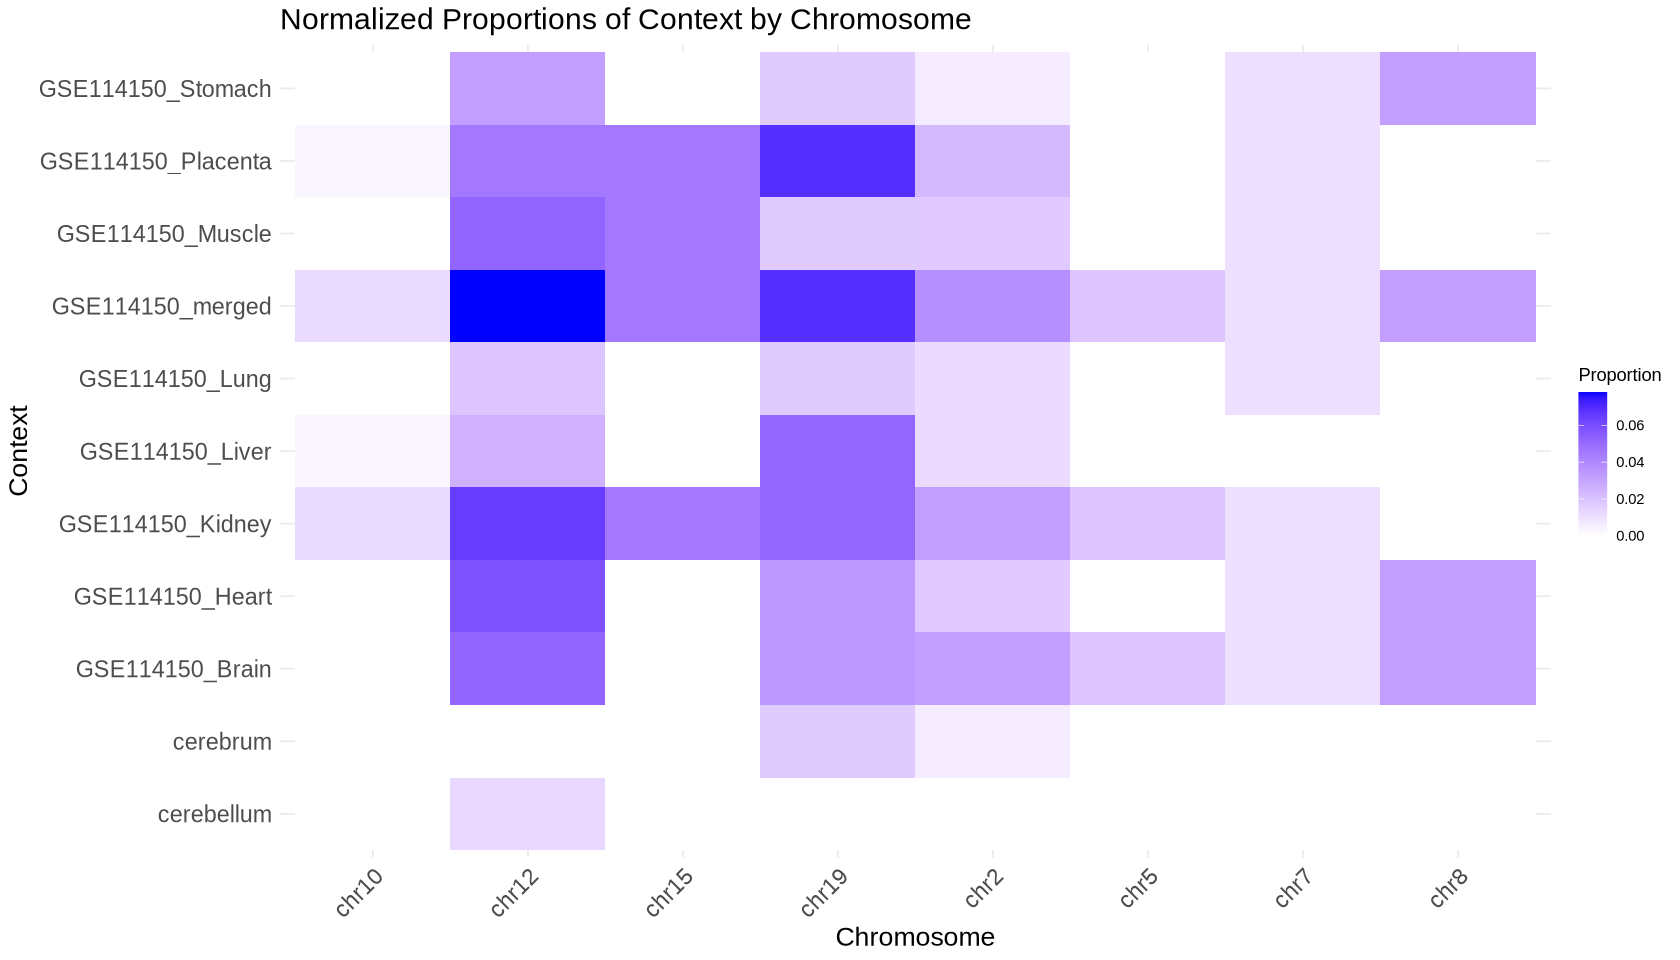

In [93]:
# Convert normalized_table to a data frame
normalized_df <- as.data.frame(as.table(normalized_table))

# Rename columns for clarity
colnames(normalized_df) <- c("Context", "Chromosome", "Proportion")
library(ggplot2)

# Plot the normalized table as a heatmap
ggplot(normalized_df, aes(x = Chromosome, y = Context, fill = Proportion)) +
  geom_tile() +   # Use tiles for the heatmap
  scale_fill_gradient(low = "white", high = "blue") +  # Customize colors
  labs(title = "Normalized Proportions of Context by Chromosome",
       x = "Chromosome", 
       y = "Context",
       fill = "Proportion") +
  theme_minimal() +
  theme(  axis.text.x = element_text(angle = 45, hjust = 1, size = 14),  # Increase font size for x-axis labels
    axis.text.y = element_text(size = 14),  # Increase font size for y-axis labels
    axis.title.x = element_text(size = 16),  # Increase font size for x-axis title
    axis.title.y = element_text(size = 16),  # Increase font size for y-axis title
    plot.title = element_text(size = 18)  # Increase font size for plot title
  ) 

## AD enrichment analysis 

fisher test with 1. m6A and AD loci, 2. m6a and not AD loci, 3. not m6a and AD loci, 4. not m6a and not AD loci

m6a_gene_bed_ad is the peak regions has AD variants in them 

In [32]:
m6a_gene_bed_ad %>% filter(context == 'GSE114150_merged') 

chrom,start,end,hg38_ID,context,gene_id,gene_name,chr,start_variant,end_variant,variant_id,z,pip,cs_coverage_0.95_min_corr,block,study
<chr>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<chr>,<dbl>,<dbl>,<int>,<chr>,<chr>
chr10,58269167,58269407,chr10:58269167:58269407,GSE114150_merged,ENSG00000122873,CISD1,chr10,58269403,58269403,10:58269403:C:T,-4.010101,0.003389421,1,chr10_57667362_59558848,AD_Bellenguez_2022
chr10,96266187,96266701,chr10:96266187:96266701,GSE114150_merged,ENSG00000095585,BLNK,chr10,96266318,96266318,10:96266318:A:G,5.182243,0.032637387,1,chr10_95280986_98320874,AD_Bellenguez_2022
chr10,96266187,96266701,chr10:96266187:96266701,GSE114150_merged,ENSG00000095585,BLNK,chr10,96266554,96266554,10:96266554:A:G,5.205607,0.036940414,1,chr10_95280986_98320874,AD_Bellenguez_2022
chr10,96266187,96266701,chr10:96266187:96266701,GSE114150_merged,ENSG00000095585,BLNK,chr10,96266650,96266650,10:96266650:G:A,5.224299,0.040605957,1,chr10_95280986_98320874,AD_Bellenguez_2022
chr12,113158529,113159178,chr12:113158529:113159178,GSE114150_merged,ENSG00000186710,CFAP73,chr12,113159061,113159061,12:113159061:G:A,4.575949,0.006127578,1,chr12_112825713_115165608,AD_Bellenguez_2022
chr12,113158529,113159178,chr12:113158529:113159178,GSE114150_merged,ENSG00000123064,DDX54,chr12,113159061,113159061,12:113159061:G:A,4.575949,0.006127578,1,chr12_112825713_115165608,AD_Bellenguez_2022
chr12,113161818,113162088,chr12:113161818:113162088,GSE114150_merged,ENSG00000123064,DDX54,chr12,113162061,113162061,12:113162061:T:C,4.490323,0.004234860,1,chr12_112825713_115165608,AD_Bellenguez_2022
chr12,113162795,113163268,chr12:113162795:113163268,GSE114150_merged,ENSG00000123064,DDX54,chr12,113163098,113163098,12:113163098:A:G,4.483871,0.004119767,1,chr12_112825713_115165608,AD_Bellenguez_2022
chr12,113162795,113163268,chr12:113162795:113163268,GSE114150_merged,ENSG00000123064,DDX54,chr12,113163135,113163135,12:113163135:C:T,4.518987,0.004788665,1,chr12_112825713_115165608,AD_Bellenguez_2022


In [33]:
m6a_gene_bed_ad %>% filter(context %in% c('GSE114150_Brain','cerebellum','cerebrum','Hypothalamus')) 

chrom,start,end,hg38_ID,context,gene_id,gene_name,chr,start_variant,end_variant,variant_id,z,pip,cs_coverage_0.95_min_corr,block,study
<chr>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<chr>,<dbl>,<dbl>,<int>,<chr>,<chr>
chr12,113158551,113159178,chr12:113158551:113159178,GSE114150_Brain,ENSG00000186710,CFAP73,chr12,113159061,113159061,12:113159061:G:A,4.575949,0.006127578,1,chr12_112825713_115165608,AD_Bellenguez_2022
chr12,113158551,113159178,chr12:113158551:113159178,GSE114150_Brain,ENSG00000123064,DDX54,chr12,113159061,113159061,12:113159061:G:A,4.575949,0.006127578,1,chr12_112825713_115165608,AD_Bellenguez_2022
chr12,113161821,113162088,chr12:113161821:113162088,GSE114150_Brain,ENSG00000123064,DDX54,chr12,113162061,113162061,12:113162061:T:C,4.490323,0.004234860,1,chr12_112825713_115165608,AD_Bellenguez_2022
chr12,113162795,113163180,chr12:113162795:113163180,GSE114150_Brain,ENSG00000123064,DDX54,chr12,113163098,113163098,12:113163098:A:G,4.483871,0.004119767,1,chr12_112825713_115165608,AD_Bellenguez_2022
chr12,113162795,113163180,chr12:113162795:113163180,GSE114150_Brain,ENSG00000123064,DDX54,chr12,113163135,113163135,12:113163135:C:T,4.518987,0.004788665,1,chr12_112825713_115165608,AD_Bellenguez_2022
chr12,113191735,113192015,chr12:113191735:113192015,GSE114150_Brain,ENSG00000139405,RITA1,chr12,113191832,113191832,12:113191832:G:A,4.449367,0.003557680,1,chr12_112825713_115165608,AD_Bellenguez_2022
chr12,113220931,113221081,chr12:113220931:113221081,GSE114150_Brain,ENSG00000166578,IQCD,chr12,113221042,113221042,12:113221042:G:A,4.563291,0.005799341,1,chr12_112825713_115165608,AD_Bellenguez_2022
chr12,113220931,113221081,chr12:113220931:113221081,GSE114150_Brain,ENSG00000186815,TPCN1,chr12,113221042,113221042,12:113221042:G:A,4.563291,0.005799341,1,chr12_112825713_115165608,AD_Bellenguez_2022
chr19,1854218,1854735,chr19:1854218:1854735,GSE114150_Brain,ENSG00000129911,KLF16,chr19,1854254,1854254,19:1854254:G:GC,-5.815217,0.165940073,1,chr19_1507536_3368979,AD_Bellenguez_2022


### load GWAS sumstats to get all GWAS variants 

In [34]:
all_gwas <- fread('/mnt/vast/hpc/csg/hs3393/RSS_QC/GWAS_finemapping_Apr9/RSS_QC_RAISS_imputed_concatenate_result/AD_Bellenguez_2022_RSS_QC_RAISS_imputed.tsv.gz')

In [35]:
# extract the GWAS table without AD loci
non_ad_df <- all_gwas %>% filter(!(variant_id %in% gwas[gwas$study =='AD_Bellenguez_2022',]$variant_id))%>% 
            mutate(chr = str_split(variant_id, ":", simplify = T) %>% .[,1] %>% paste0("chr",.),
                pos = str_split(variant_id, ":", simplify = T) %>% .[,2] %>% as.numeric) 

### map the m6a region to non-AD GWAS table

In [94]:
m6a_gene_anno_bed <- m6a_gene_anno[, c("V1", "start", "end", "hg38_ID", "context", "gene_id", "gene_name")]
non_adgwas_bed <- non_ad_df[, .(chr, start_variant = as.integer(pos), end_variant = as.integer(pos), variant_id)]

m6a_non_gene_bed_ad <- bt.intersect(a = m6a_gene_anno_bed, b = non_adgwas_bed, wa = T, wb = T) 

In [95]:
colnames(m6a_non_gene_bed_ad) <- c("chrom", "start", "end", "hg38_ID", "context", "gene_id", "gene_name", colnames(non_adgwas_bed))
m6a_non_gene_bed_ad %>% head

,chrom,start,end,hg38_ID,context,gene_id,gene_name,chr,start_variant,end_variant,variant_id
,<chr>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<chr>
1,chr1,958977,959238,chr1:958977:959238,GSE114150_Brain,ENSG00000188976,NOC2L,chr1,959139,959139,1:959139:G:A
2,chr1,958977,959238,chr1:958977:959238,GSE114150_Brain,ENSG00000188976,NOC2L,chr1,959193,959193,1:959193:G:A
3,chr1,1027235,1027730,chr1:1027235:1027730,GSE114150_Brain,ENSG00000188157,AGRN,chr1,1027340,1027340,1:1027340:C:T
4,chr1,1027235,1027730,chr1:1027235:1027730,GSE114150_Brain,ENSG00000188157,AGRN,chr1,1027450,1027450,1:1027450:T:G
5,chr1,1027235,1027730,chr1:1027235:1027730,GSE114150_Brain,ENSG00000188157,AGRN,chr1,1027511,1027511,1:1027511:C:T
6,chr1,1027235,1027730,chr1:1027235:1027730,GSE114150_Brain,ENSG00000188157,AGRN,chr1,1027633,1027633,1:1027633:C:T


### Enrichment analysis with fisher test
To generate 2x2 table:    
- ad_m6a: The number of variants within both AD loci and are m6A sites.
- ad_non_m6a: The number of variants within AD loci but not m6A sites.
- m6a_non_ad: The number of variants outside of AD loci but are m6A sites.
- non_m6a_non_ad: The number variants outside of AD loci also not m6A sites.
    
The first two categories can be calculated by finding the intersection between the m6A regions and the AD GWAS loci. The latter two categories can be calculated by finding the intersection between the m6A regions and the non-AD GWAS loci.

`intersected_data` from above analysis is the intersected table for m6A peak regions and AD GWAS loci table

`intersected_data_non_ad` here is the intersected table for m6A peak regions and non-AD GWAS loci table


The FET section: the table is focused on Bellenguez et al 2022 and is on variant level. Although I eyeballed 11 CS (we can get an accurate number) and I  know that Bellenguez has maybe 70 CS fine-mapped. So 11 out of 70 CS contain some m6A peaks. The test is still on variants though because I dont know how to make the test on CS ..

In [99]:
perform_fisher_test <- function(adgwas, all_gwas, m6a_ad, m6a_not_ad, test_context, greater = FALSE) {
  # Define the total number of AD variants
  ad <- length(adgwas[adgwas$study == 'AD_Bellenguez_2022',]$variant_id %>% unique())
  
  # Number of AD loci in m6A regions
  ad_m6a_df <- m6a_ad %>% filter(context %in% test_context)
  ad_m6a <- length(ad_m6a_df$variant_id %>% unique())
  
  # Number of AD loci outside m6A regions
  ad_non_m6a <- ad - ad_m6a
  
  # Total number of non-AD variants from GWAS concatenate sumstats
  non_ad <- length(all_gwas$variant_id %>% unique()) - ad
  
  # Number of non-AD loci in m6A regions
  m6a_non_ad_df <- m6a_not_ad %>% filter(context %in% test_context)
  m6a_non_ad <- length(m6a_non_ad_df$variant_id %>% unique())
  
  # Number of non-AD loci outside m6A regions
  non_m6a_non_ad <- non_ad - m6a_non_ad
  
  # Create the contingency table
  contingency_table <- matrix(c(ad_m6a, ad_non_m6a, m6a_non_ad, non_m6a_non_ad),
                              nrow = 2,
                              byrow = TRUE,
                              dimnames = list("AD" = c("AD", "not_AD"),
                                              "m6A" = c("m6A", "not_m6A")))
  

  # Perform Fisher's Exact Test
  if(greater) fisher_test_result <- fisher.test(contingency_table, alternative = "greater") else fisher_test_result <- fisher.test(contingency_table)

  return(list(data = contingency_table, res = fisher_test_result))
}


In [97]:
# The number of variants within both AD loci and are m6A sites in different contexts
m6a_gene_bed_ad %>% distinct(context, variant_id, .keep_all = TRUE) %>% pull(context) %>% table

.
        cerebellum           cerebrum    GSE114150_Brain    GSE114150_Heart 
                 2                  2                 18                 16 
  GSE114150_Kidney    GSE114150_Liver     GSE114150_Lung   GSE114150_merged 
                26                 11                  8                 30 
  GSE114150_Muscle GSE114150_Placenta  GSE114150_Stomach 
                14                 19                 10 

In [98]:
# The number of variants within both non-AD loci and are m6A sites in different contexts
m6a_non_gene_bed_ad %>% distinct(context, variant_id, .keep_all = TRUE) %>% pull(context) %>% table

.
        cerebellum           cerebrum    GSE114150_Brain    GSE114150_Heart 
             12236              16848              75191              42598 
  GSE114150_Kidney    GSE114150_Liver     GSE114150_Lung   GSE114150_merged 
             86650              38289              39834             140595 
  GSE114150_Muscle GSE114150_Placenta  GSE114150_Stomach       Hypothalamus 
             55354              64046              38073               5824 

Just show the details for `merged` and `Brian` here

In [103]:
# Two-sided test
perform_fisher_test(adgwas = gwas, all_gwas = all_gwas, m6a_ad = m6a_gene_bed_ad, m6a_not_ad = m6a_non_gene_bed_ad, test_context = c('GSE114150_Brain','cerebellum','cerebrum','Hypothalamus')) 

$data
        m6A
AD         m6A  not_m6A
  AD        20     1263
  not_AD 93557 12113078

$res

	Fisher's Exact Test for Count Data

data:  contingency_table
p-value = 0.003331
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 1.247953 3.180537
sample estimates:
odds ratio 
  2.050241 



for other contexts, just show the pvalue for them ( two-sided)

In [101]:
contexts <- m6a_gene_anno_bed %>% pull(context) %>% unique
for(test_context in contexts){
    message(test_context,":",perform_fisher_test(adgwas = gwas, all_gwas = all_gwas, m6a_ad = m6a_gene_bed_ad, m6a_not_ad = m6a_non_gene_bed_ad, test_context = test_context)$res$p.value)
}

GSE114150_Brain:0.00170783178965425

GSE114150_Heart:1.82234233114467e-05

GSE114150_Kidney:3.2503989334749e-06

GSE114150_Liver:0.00292249902068156

GSE114150_Lung:0.0778295043433078

GSE114150_merged:0.000346147666541701

GSE114150_Muscle:0.00271227729392887

GSE114150_Placenta:7.50263296649612e-05

GSE114150_Stomach:0.00805683048277676

cerebellum:0.368322587124875

cerebrum:0.698572568449092

Hypothalamus:1



In most contexts, there is an enrichment of AD loci in m6A regions, which may be inflated due to the non-independence of variants in LD?

## compare brain m6A peaks vs. m6A peaks in all other tissues
set A = brain specific, set B = both brain and other tissues, set C = other tissues but not brains. 


The test would be  1) number of "brain m6A" overlapping with Bellenguez 2022 AD CS  (AD CS hereafter) 2) number of "brain m6A" non-overlapping with AD CS, 3) number of "non-brain m6A" overlapping with AD CS , 4) number of "non-brain m6A" non-overlapping with AD CS.

when we talk about the overlap between peak regions here, if we only focus on the exactly region: same start and end. Then brain and other tissue do not have overlap. 

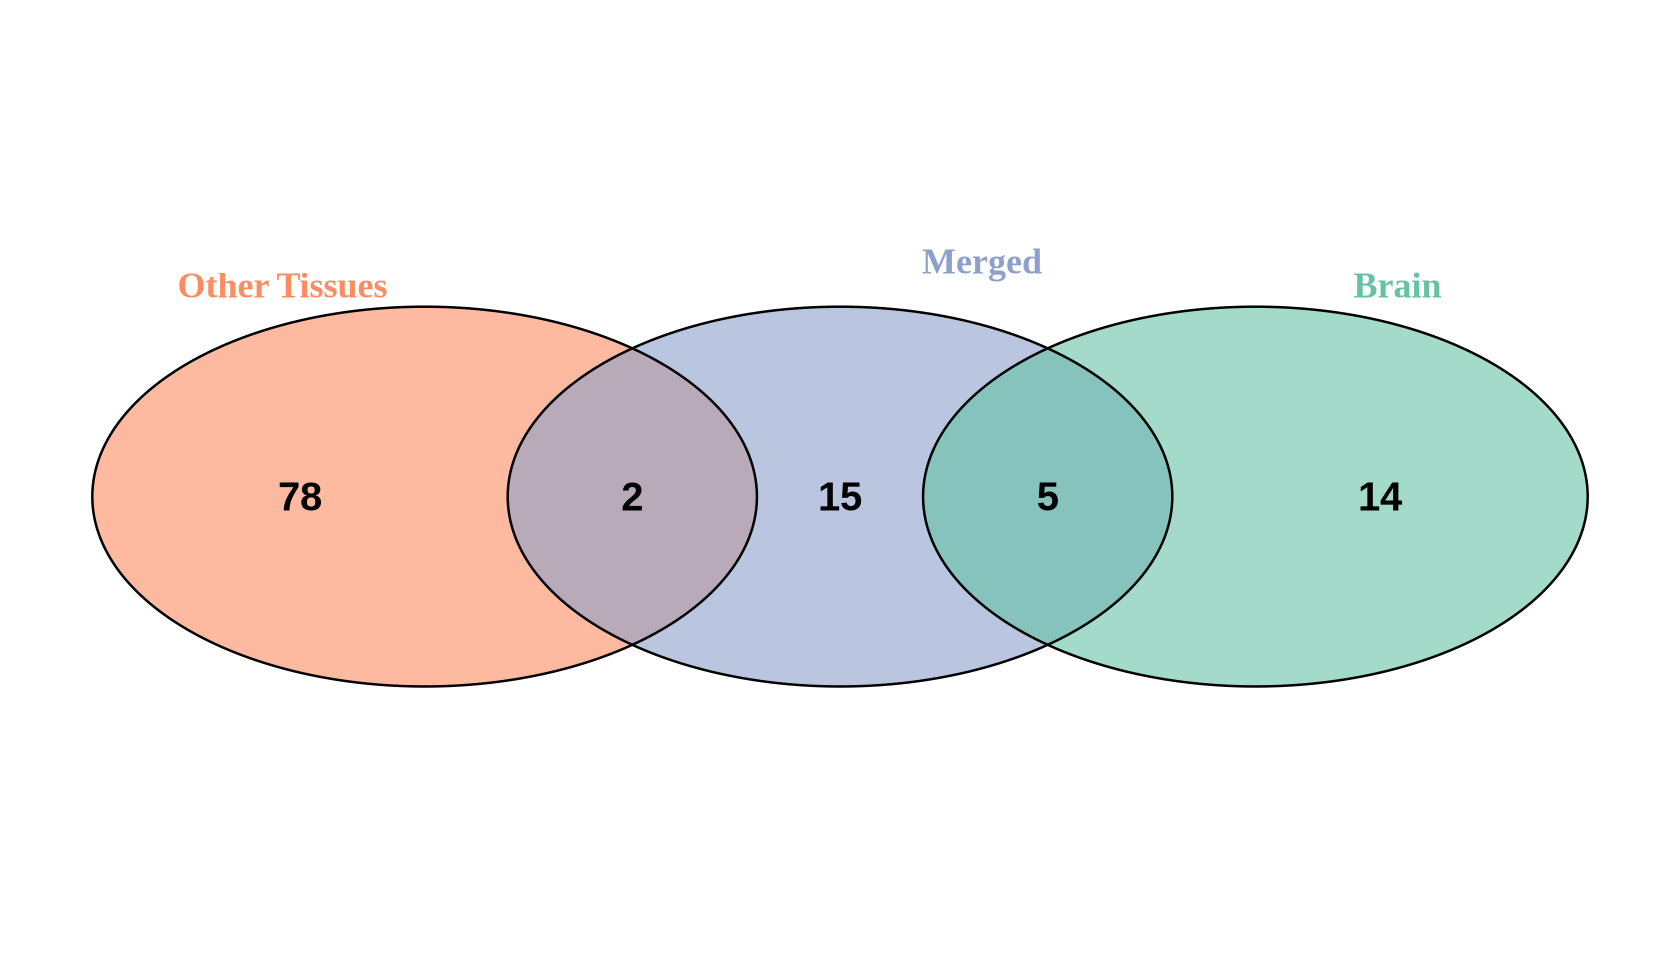

In [104]:
library(VennDiagram)
library(dplyr)

brain <- m6a_gene_bed_ad %>%
  filter(context %in% c('GSE114150_Brain','cerebellum','cerebrum','Hypothalamus')) %>%
  pull(hg38_ID)

other <- m6a_gene_bed_ad %>%
  filter(!(context %in% c('GSE114150_Brain','cerebellum','cerebrum','Hypothalamus')),!(context %in% c('GSE114150_Brain','cerebellum','cerebrum','Hypothalamus'))) %>%
  pull(hg38_ID)

merged <- m6a_gene_bed_ad %>%
  filter(context == 'GSE114150_merged') %>%
  pull(hg38_ID)

venn_data <- list(
  "Brain" = brain,
  "Other Tissues" = other,
  "Merged" = merged
)

venn.plot <- venn.diagram(
  x = venn_data,
  filename = NULL,  
  fill = c("#66c2a5", "#fc8d62", "#8da0cb"),  # 
  alpha = 0.6,  # 
  cex = 2,  # 
  fontface = "bold",  # 
  fontfamily = "sans",  # 
  cat.col = c("#66c2a5", "#fc8d62", "#8da0cb"),  # 
  cat.cex = 1.8,  # 
  cat.fontface = "bold",  # 
  cat.pos = c(-20, 20, 20),  # 
  cat.dist = c(0.05, 0.05, 0.05),  # 
  margin = 0.05,  # 
  lwd = 2,  # 
  lty = "solid",  # 
  col = "black"  # 
)

grid.draw(venn.plot)

If we accept overlapping regions, meaning that regions with different start and end coordinates (e.g., chr1:1-100 and chr1:20-120) can be considered the same, then almost all brain peaks are covered by peaks from other tissues. However, the numbers shown in the plot do not reflect the actual number of peaks, as they are influenced by the cutoffs applied to define peak regions. Moreover, I am unsure how to easily compare the regions based on this overlapping definition.

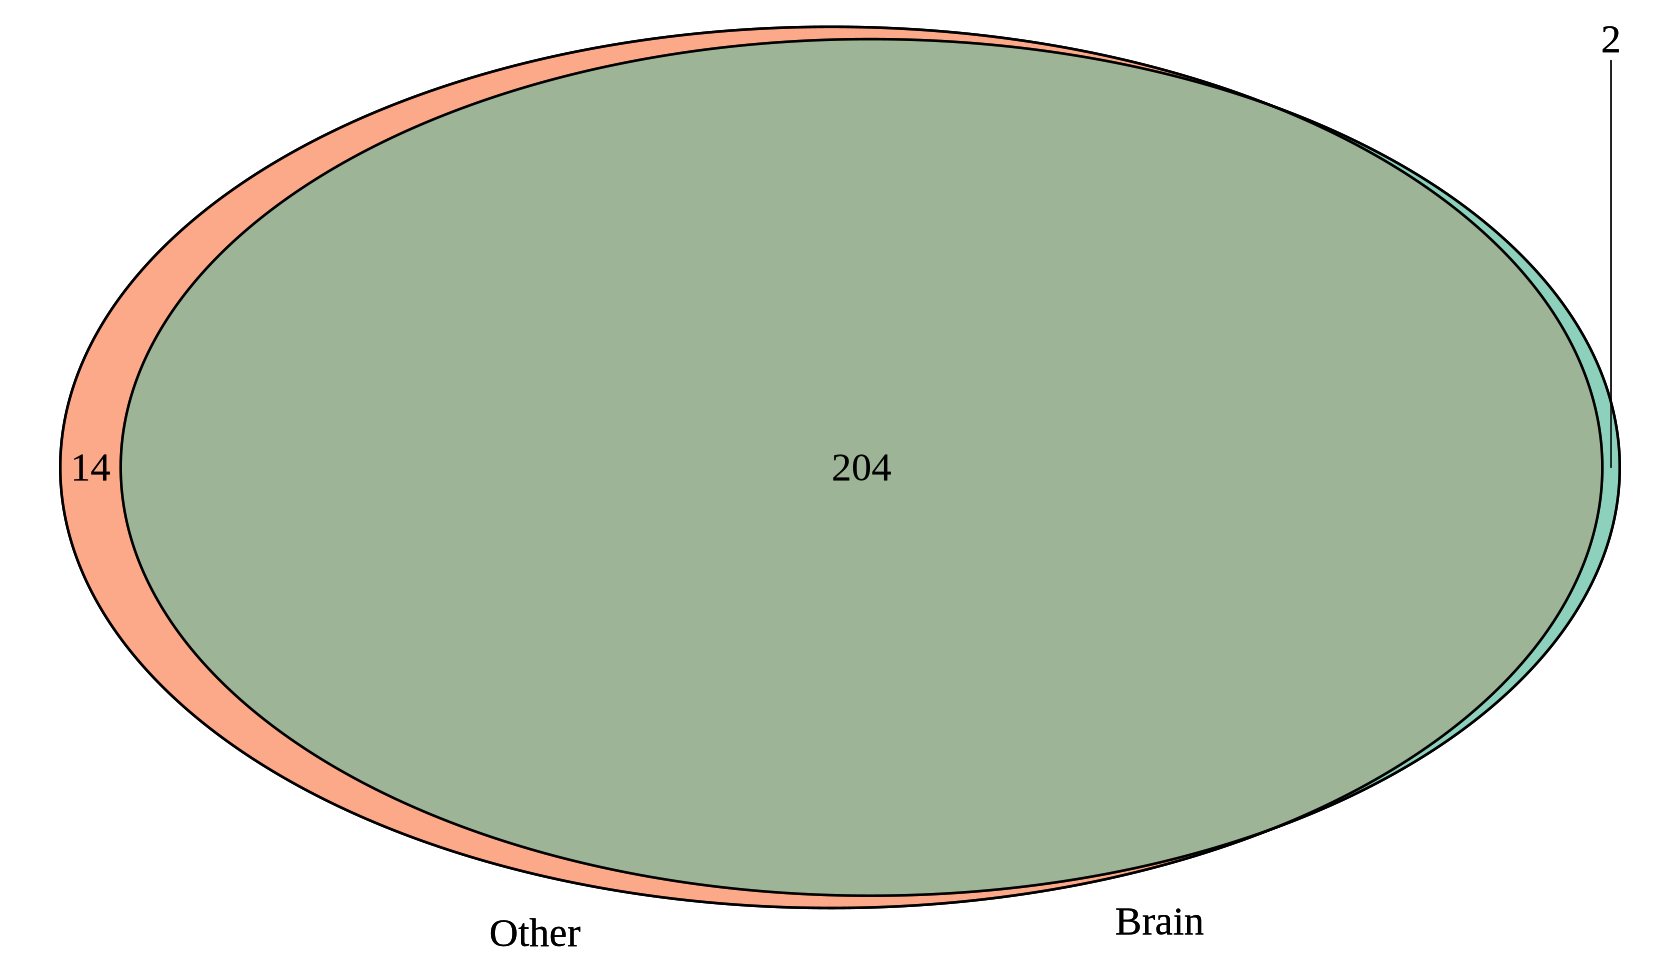

In [106]:

# Helper function to convert region string into GRanges object
convert_to_granges <- function(region_list) {
  parsed_regions <- do.call(rbind, strsplit(region_list, ":"))
  gr <- GRanges(seqnames = parsed_regions[,1],
                ranges = IRanges(start = as.numeric(parsed_regions[,2]),
                                 end = as.numeric(parsed_regions[,3])))
  return(gr)
}

# Convert both region sets to GRanges
gr_brain <- convert_to_granges(brain)
gr_other <- convert_to_granges(other)

# Find overlaps between the two sets
overlaps <- findOverlaps(gr_brain, gr_other)

# Prepare counts for Venn diagram
unique_brain <- length(setdiff(seq_along(gr_brain), queryHits(overlaps)))
unique_other <- length(setdiff(seq_along(gr_other), subjectHits(overlaps)))
overlap_count <- length(queryHits(overlaps))

# Generate Venn diagram
venn.plot <- draw.pairwise.venn(area1 = unique_brain + overlap_count,
                                area2 = unique_other + overlap_count,
                                cross.area = overlap_count,
                                category = c("Brain", "Other"),
                                fill = c("#66c2a5", "#fc8d62"),
                                alpha = 0.5,
                                cex = 2,
                                cat.cex = 2,
                                cat.pos = c(-20, 20))

# Display the Venn diagram
grid.draw(venn.plot)

So I am here still using the former difinition to check sets, so there is actually no overlapped region between Brain and Other tissues, which means we don't have `B` set, the compare is simply between A and C

### use all AD signals in Bellenguez data here

#### compare brain and combined other tissues

In [108]:
brain <- m6a_gene_anno_bed %>%
  filter(context %in% c('GSE114150_Brain','cerebellum','cerebrum','Hypothalamus'))  
brain_ad <- m6a_gene_bed_ad %>%
  filter(context %in% c('GSE114150_Brain','cerebellum','cerebrum','Hypothalamus')) %>% pull(hg38_ID) %>% unique %>% length
brain_nonad <- brain %>% pull(hg38_ID) %>% unique %>% length - brain_ad
brain_ad
brain_nonad

[1] 19

[1] 94695

In [109]:
other <- m6a_gene_anno_bed %>%
  filter(!(context %in% c('GSE114150_Brain','cerebellum','cerebrum','Hypothalamus')),!(context %in% c('GSE114150_Brain','cerebellum','cerebrum','Hypothalamus'))) 
other_ad <- m6a_gene_bed_ad %>%
  filter(!(context %in% c('GSE114150_Brain','cerebellum','cerebrum','Hypothalamus')),!(context %in% c('GSE114150_Brain','cerebellum','cerebrum','Hypothalamus')))  %>% pull(hg38_ID) %>% unique %>% length
other_nonad <- other %>% pull(hg38_ID) %>% unique %>% length - other_ad
other_ad
other_nonad

[1] 80

[1] 266302

In [110]:
# Create the contingency table
contingency_table <- matrix(c(brain_ad, brain_nonad, other_ad, other_nonad),
                            nrow = 2,
                            byrow = TRUE,
                            dimnames = list("Tissue" = c("Brian", "Other"),
                                            "AD" = c("AD", "not_AD")))

# Print the contingency table
print(contingency_table)

# Perform Fisher's Exact Test
# two sides
fisher_test_result_two <- fisher.test(contingency_table)
# one side
fisher_test_result_one <- fisher.test(contingency_table, alternative = "greater")

# Print the Fisher test result
print(fisher_test_result_two)
print(fisher_test_result_one)

       AD
Tissue  AD not_AD
  Brian 19  94695
  Other 80 266302

	Fisher's Exact Test for Count Data

data:  contingency_table
p-value = 0.1366
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 0.3823101 1.1120628
sample estimates:
odds ratio 
 0.6679214 


	Fisher's Exact Test for Count Data

data:  contingency_table
p-value = 0.9598
alternative hypothesis: true odds ratio is greater than 1
95 percent confidence interval:
 0.4182645       Inf
sample estimates:
odds ratio 
 0.6679214 



#### compare brain and each other tissue

In [114]:
contexts <- m6a_gene_anno_bed %>% pull(context) %>% unique
# contexts <- contexts[contexts!= 'GSE114150_Brain' & contexts!= 'GSE114150_merged']
contexts <- contexts[!(contexts %in% c('GSE114150_Brain', 'cerebellum', 'cerebrum', 'Hypothalamus'))]

In [116]:
brain <- m6a_gene_anno_bed %>%
  filter(context %in% c('GSE114150_Brain','cerebellum','cerebrum','Hypothalamus'))  
brain_ad <- m6a_gene_bed_ad %>%
  filter(context %in% c('GSE114150_Brain','cerebellum','cerebrum','Hypothalamus')) %>% pull(hg38_ID) %>% unique %>% length
brain_nonad <- brain %>% pull(hg38_ID) %>% unique %>% length - brain_ad

for(context_target in contexts){
    other <- m6a_gene_anno_bed %>%
      filter(context == context_target) 
    other_ad <- m6a_gene_bed_ad %>%
      filter(context == context_target)  %>% pull(hg38_ID) %>% unique %>% length
    other_nonad <- other %>% pull(hg38_ID) %>% unique %>% length - other_ad
    
    # Create the contingency table
    contingency_table <- matrix(c(brain_ad, brain_nonad, other_ad, other_nonad),
                                nrow = 2,
                                byrow = TRUE,
                                dimnames = list("Tissue" = c("Brian", context_target),
                                                "AD" = c("AD", "not_AD")))

    message("Brian AD vs ", context_target, " AD")
    
    # Print the contingency table
    print(contingency_table)
        # two sides
    fisher_test_result_two <- fisher.test(contingency_table)
    # one side
    fisher_test_result_one <- fisher.test(contingency_table, alternative = "greater")
    
    # Print the Fisher test result
    print(paste('Two-sided Fisher exact test pvalue:',fisher_test_result_two$p.value, 'with odds:', fisher_test_result_two$estimate))
    print(paste('One-sided Fisher exact test pvalue:',fisher_test_result_one$p.value, 'with odds:', fisher_test_result_one$estimate))
}

Brian AD vs GSE114150_Heart AD



                 AD
Tissue            AD not_AD
  Brian           19  94695
  GSE114150_Heart 13  34035
[1] "Two-sided Fisher exact test pvalue: 0.0735451058744186 with odds: 0.525333746032768"
[1] "One-sided Fisher exact test pvalue: 0.974382820498625 with odds: 0.525333746032768"


Brian AD vs GSE114150_Kidney AD



                  AD
Tissue             AD not_AD
  Brian            19  94695
  GSE114150_Kidney 20  58513
[1] "Two-sided Fisher exact test pvalue: 0.100572782966678 with odds: 0.587039773430185"
[1] "One-sided Fisher exact test pvalue: 0.966098702610593 with odds: 0.587039773430185"


Brian AD vs GSE114150_Liver AD



                 AD
Tissue            AD not_AD
  Brian           19  94695
  GSE114150_Liver  8  31989
[1] "Two-sided Fisher exact test pvalue: 0.657498331219838 with odds: 0.802292178479038"
[1] "One-sided Fisher exact test pvalue: 0.776737115169175 with odds: 0.802292178479038"


Brian AD vs GSE114150_Lung AD



                AD
Tissue           AD not_AD
  Brian          19  94695
  GSE114150_Lung  6  30120
[1] "Two-sided Fisher exact test pvalue: 1 with odds: 1.00723442175213"
[1] "One-sided Fisher exact test pvalue: 0.601251768324548 with odds: 1.00723442175213"


Brian AD vs GSE114150_merged AD



                  AD
Tissue             AD not_AD
  Brian            19  94695
  GSE114150_merged 22  90676
[1] "Two-sided Fisher exact test pvalue: 0.639883998258905 with odds: 0.82698465153382"
[1] "One-sided Fisher exact test pvalue: 0.777396675073316 with odds: 0.82698465153382"


Brian AD vs GSE114150_Muscle AD



                  AD
Tissue             AD not_AD
  Brian            19  94695
  GSE114150_Muscle 11  37190
[1] "Two-sided Fisher exact test pvalue: 0.312753352399646 with odds: 0.678362002706845"
[1] "One-sided Fisher exact test pvalue: 0.889195215039461 with odds: 0.678362002706845"


Brian AD vs GSE114150_Placenta AD



                    AD
Tissue               AD not_AD
  Brian              19  94695
  GSE114150_Placenta 15  47946
[1] "Two-sided Fisher exact test pvalue: 0.206136760348714 with odds: 0.641323436989522"
[1] "One-sided Fisher exact test pvalue: 0.927915916527129 with odds: 0.641323436989522"


Brian AD vs GSE114150_Stomach AD



                   AD
Tissue              AD not_AD
  Brian             19  94695
  GSE114150_Stomach  7  26795
[1] "Two-sided Fisher exact test pvalue: 0.487907603949396 with odds: 0.768039236406502"
[1] "One-sided Fisher exact test pvalue: 0.802131745255728 with odds: 0.768039236406502"


There is no significant difference between Brain-AD enrichment and other tissue-AD enrichment. No matter for two-sided or one-sided. 

### in 245 gene list
Then I am wondering if we can get significant difference if we use our AD genelist as background... Which is a 245 genelist from our sharing QTL-AD sharing evidence, could be a potential AD risk gene list. 

#### compare brain and combined other tissues

In [118]:
ad_genes <- fread('/mnt/vast/hpc/csg/rf2872/data/resource_Ru/Fungen_xQTL.overlapped.gwas.min_corr_gwas95_qtl70.Apr.tsv')

In [119]:
brain <- m6a_gene_anno_bed %>%
  filter(context %in% c('GSE114150_Brain','cerebellum','cerebrum','Hypothalamus'), gene_id %in% ad_genes$region_id)  
brain_ad <- m6a_gene_bed_ad %>%
  filter(context %in% c('GSE114150_Brain','cerebellum','cerebrum','Hypothalamus'), gene_id %in% ad_genes$region_id) %>% pull(hg38_ID) %>% unique %>% length
brain_nonad <- (brain %>% pull(hg38_ID) %>% unique %>% length) - brain_ad
brain_ad
brain_nonad

[1] 12

[1] 1629

In [120]:
other <- m6a_gene_anno_bed %>%
  filter(context != 'GSE114150_Brain',!(context %in% c('GSE114150_Brain','cerebellum','cerebrum','Hypothalamus')), gene_id %in% ad_genes$region_id) 
other_ad <- m6a_gene_bed_ad %>%
  filter(context != 'GSE114150_Brain',!(context %in% c('GSE114150_Brain','cerebellum','cerebrum','Hypothalamus')), gene_id %in% ad_genes$region_id)  %>% pull(hg38_ID) %>% unique %>% length
other_nonad <- other %>% pull(hg38_ID) %>% unique %>% length - other_ad
other_ad
other_nonad

[1] 58

[1] 5782

In [121]:
# Create the contingency table
contingency_table <- matrix(c(brain_ad, brain_nonad, other_ad, other_nonad),
                            nrow = 2,
                            byrow = TRUE,
                            dimnames = list("Tissue" = c("Brian", "Other"),
                                            "AD" = c("AD", "not_AD")))

# Print the contingency table
print(contingency_table)

# Perform Fisher's Exact Test
# two sides
fisher_test_result_two <- fisher.test(contingency_table)
# one side
fisher_test_result_one <- fisher.test(contingency_table, alternative = "greater")

# Print the Fisher test result
print(fisher_test_result_two)
print(fisher_test_result_one)

       AD
Tissue  AD not_AD
  Brian 12   1629
  Other 58   5782

	Fisher's Exact Test for Count Data

data:  contingency_table
p-value = 0.3855
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 0.3580503 1.3866294
sample estimates:
odds ratio 
 0.7343957 


	Fisher's Exact Test for Count Data

data:  contingency_table
p-value = 0.8702
alternative hypothesis: true odds ratio is greater than 1
95 percent confidence interval:
 0.4023343       Inf
sample estimates:
odds ratio 
 0.7343957 



#### compare brain and each other tissue

In [124]:
contexts <- m6a_gene_anno_bed %>% pull(context) %>% unique
contexts <- contexts[!(contexts %in% c('GSE114150_Brain','cerebellum','cerebrum','Hypothalamus'))]

In [125]:
brain <- m6a_gene_anno_bed %>%
  filter(context %in% c('GSE114150_Brain','cerebellum','cerebrum','Hypothalamus'), gene_id %in% ad_genes$region_id)  
brain_ad <- m6a_gene_bed_ad %>%
  filter(context %in% c('GSE114150_Brain','cerebellum','cerebrum','Hypothalamus'), gene_id %in% ad_genes$region_id) %>% pull(hg38_ID) %>% unique %>% length
brain_nonad <- brain %>% pull(hg38_ID) %>% unique %>% length - brain_ad

for(context_target in contexts){
    other <- m6a_gene_anno_bed %>%
      filter(context == context_target, gene_id %in% ad_genes$region_id) 
    other_ad <- m6a_gene_bed_ad %>%
      filter(context == context_target, gene_id %in% ad_genes$region_id)  %>% pull(hg38_ID) %>% unique %>% length
    other_nonad <- other %>% pull(hg38_ID) %>% unique %>% length - other_ad
    
    # Create the contingency table
    contingency_table <- matrix(c(brain_ad, brain_nonad, other_ad, other_nonad),
                                nrow = 2,
                                byrow = TRUE,
                                dimnames = list("Tissue" = c("Brian", context_target),
                                                "AD" = c("AD", "not_AD")))

    message("Brian AD vs ", context_target, " AD")
    
    # Print the contingency table
    print(contingency_table)
        # two sides
    fisher_test_result_two <- fisher.test(contingency_table)
    # one side
    fisher_test_result_one <- fisher.test(contingency_table, alternative = "greater")
    
     # Print the Fisher test result
    print(paste('Two-sided Fisher exact test pvalue:',fisher_test_result_two$p.value, 'with odds:', fisher_test_result_two$estimate))
    print(paste('One-sided Fisher exact test pvalue:',fisher_test_result_one$p.value, 'with odds:', fisher_test_result_one$estimate))
}

Brian AD vs GSE114150_Heart AD



                 AD
Tissue            AD not_AD
  Brian           12   1629
  GSE114150_Heart  7    647
[1] "Two-sided Fisher exact test pvalue: 0.446259247432526 with odds: 0.680996156191319"
[1] "One-sided Fisher exact test pvalue: 0.855975896458542 with odds: 0.680996156191319"


Brian AD vs GSE114150_Kidney AD



                  AD
Tissue             AD not_AD
  Brian            12   1629
  GSE114150_Kidney 13   1065
[1] "Two-sided Fisher exact test pvalue: 0.221795812601447 with odds: 0.603620119852598"
[1] "One-sided Fisher exact test pvalue: 0.928357724503703 with odds: 0.603620119852598"


Brian AD vs GSE114150_Liver AD



                 AD
Tissue            AD not_AD
  Brian           12   1629
  GSE114150_Liver  5    575
[1] "Two-sided Fisher exact test pvalue: 0.782811274540951 with odds: 0.847236243598037"
[1] "One-sided Fisher exact test pvalue: 0.730814846561873 with odds: 0.847236243598037"


Brian AD vs GSE114150_Lung AD



                AD
Tissue           AD not_AD
  Brian          12   1629
  GSE114150_Lung  3    556
[1] "Two-sided Fisher exact test pvalue: 0.772935531312615 with odds: 1.36505363585183"
[1] "One-sided Fisher exact test pvalue: 0.446176498048001 with odds: 1.36505363585183"


Brian AD vs GSE114150_merged AD



                  AD
Tissue             AD not_AD
  Brian            12   1629
  GSE114150_merged 15   1576
[1] "Two-sided Fisher exact test pvalue: 0.565177099441765 with odds: 0.774035405963915"
[1] "One-sided Fisher exact test pvalue: 0.803254272008216 with odds: 0.774035405963915"


Brian AD vs GSE114150_Muscle AD



                  AD
Tissue             AD not_AD
  Brian            12   1629
  GSE114150_Muscle  5    654
[1] "Two-sided Fisher exact test pvalue: 1 with odds: 0.963549991531514"
[1] "One-sided Fisher exact test pvalue: 0.644805336188341 with odds: 0.963549991531514"


Brian AD vs GSE114150_Placenta AD



                    AD
Tissue               AD not_AD
  Brian              12   1629
  GSE114150_Placenta  9    837
[1] "Two-sided Fisher exact test pvalue: 0.487974082550007 with odds: 0.685168970271678"
[1] "One-sided Fisher exact test pvalue: 0.86153511973243 with odds: 0.685168970271678"


Brian AD vs GSE114150_Stomach AD



                   AD
Tissue              AD not_AD
  Brian             12   1629
  GSE114150_Stomach  3    510
[1] "Two-sided Fisher exact test pvalue: 1 with odds: 1.25217195575514"
[1] "One-sided Fisher exact test pvalue: 0.504265417339911 with odds: 1.25217195575514"


which is even more unsignificant...

### in different chromosome
what about if we focus on different chromosome?.. If there is some chromosome can show Brain peak specificty, e.g. chr19?

#### compare brain and combined other tissues

In [126]:
for(i in 1:22){
    chromosome = paste0('chr',i)
    message(chromosome)
    brain <- m6a_gene_anno_bed %>%
      filter(context %in% c('GSE114150_Brain','cerebellum','cerebrum','Hypothalamus'), V1 == chromosome)  
    brain_ad <- m6a_gene_bed_ad %>%
      filter(context %in% c('GSE114150_Brain','cerebellum','cerebrum','Hypothalamus'), chrom == chromosome) %>% pull(hg38_ID) %>% unique %>% length
    brain_nonad <- (brain %>% pull(hg38_ID) %>% unique %>% length) - brain_ad
    
    other <- m6a_gene_anno_bed %>%
      filter(context != 'GSE114150_Brain',!(context %in% c('GSE114150_Brain','cerebellum','cerebrum','Hypothalamus')), V1 == chromosome) 
    other_ad <- m6a_gene_bed_ad %>%
      filter(context != 'GSE114150_Brain',!(context %in% c('GSE114150_Brain','cerebellum','cerebrum','Hypothalamus')), chrom == chromosome)  %>% pull(hg38_ID) %>% unique %>% length
    other_nonad <- other %>% pull(hg38_ID) %>% unique %>% length - other_ad
    
    # Create the contingency table
    contingency_table <- matrix(c(brain_ad, brain_nonad, other_ad, other_nonad),
                                nrow = 2,
                                byrow = TRUE,
                                dimnames = list("Tissue" = c("Brian", "Other"),
                                                "AD" = c("AD", "not_AD")))
    
    # Perform Fisher's Exact Test
    # two sides
    fisher_test_result_two <- fisher.test(contingency_table)
    # one side
    fisher_test_result_one <- fisher.test(contingency_table, alternative = "greater")
    
    # Print the Fisher test result
    print(paste('Two-sided Fisher exact test pvalue:',fisher_test_result_two$p.value, 'with odds:', fisher_test_result_two$estimate))
    print(paste('One-sided Fisher exact test pvalue:',fisher_test_result_one$p.value, 'with odds:', fisher_test_result_one$estimate))
}

chr1



[1] "Two-sided Fisher exact test pvalue: 1 with odds: 0"
[1] "One-sided Fisher exact test pvalue: 1 with odds: 0"


chr2



[1] "Two-sided Fisher exact test pvalue: 0.542969606591685 with odds: 0.697014981580857"
[1] "One-sided Fisher exact test pvalue: 0.843553784204272 with odds: 0.697014981580857"


chr3



[1] "Two-sided Fisher exact test pvalue: 1 with odds: 0"
[1] "One-sided Fisher exact test pvalue: 1 with odds: 0"


chr4



[1] "Two-sided Fisher exact test pvalue: 1 with odds: 0"
[1] "One-sided Fisher exact test pvalue: 1 with odds: 0"


chr5



[1] "Two-sided Fisher exact test pvalue: 0.554587840944933 with odds: 1.61610698570903"
[1] "One-sided Fisher exact test pvalue: 0.554587840944933 with odds: 1.61610698570903"


chr6



[1] "Two-sided Fisher exact test pvalue: 1 with odds: 0"
[1] "One-sided Fisher exact test pvalue: 1 with odds: 0"


chr7



[1] "Two-sided Fisher exact test pvalue: 0.689184501734111 with odds: 0.452858540872345"
[1] "One-sided Fisher exact test pvalue: 0.888484414801515 with odds: 0.452858540872345"


chr8



[1] "Two-sided Fisher exact test pvalue: 1 with odds: 0.990949872958033"
[1] "One-sided Fisher exact test pvalue: 0.686505714790923 with odds: 0.990949872958033"


chr9



[1] "Two-sided Fisher exact test pvalue: 1 with odds: 0"
[1] "One-sided Fisher exact test pvalue: 1 with odds: 0"


chr10



[1] "Two-sided Fisher exact test pvalue: 0.598289063040865 with odds: 0"
[1] "One-sided Fisher exact test pvalue: 1 with odds: 0"


chr11



[1] "Two-sided Fisher exact test pvalue: 1 with odds: 0"
[1] "One-sided Fisher exact test pvalue: 1 with odds: 0"


chr12



[1] "Two-sided Fisher exact test pvalue: 0.370583535566105 with odds: 0.631825462797087"
[1] "One-sided Fisher exact test pvalue: 0.908840229549377 with odds: 0.631825462797087"


chr13



[1] "Two-sided Fisher exact test pvalue: 1 with odds: 0"
[1] "One-sided Fisher exact test pvalue: 1 with odds: 0"


chr14



[1] "Two-sided Fisher exact test pvalue: 1 with odds: 0"
[1] "One-sided Fisher exact test pvalue: 1 with odds: 0"


chr15



[1] "Two-sided Fisher exact test pvalue: 0.580431955890268 with odds: 0"
[1] "One-sided Fisher exact test pvalue: 1 with odds: 0"


chr16



[1] "Two-sided Fisher exact test pvalue: 1 with odds: 0"
[1] "One-sided Fisher exact test pvalue: 1 with odds: 0"


chr17



[1] "Two-sided Fisher exact test pvalue: 1 with odds: 0"
[1] "One-sided Fisher exact test pvalue: 1 with odds: 0"


chr18



[1] "Two-sided Fisher exact test pvalue: 1 with odds: 0"
[1] "One-sided Fisher exact test pvalue: 1 with odds: 0"


chr19



[1] "Two-sided Fisher exact test pvalue: 1 with odds: 0.84589143506793"
[1] "One-sided Fisher exact test pvalue: 0.697962113099794 with odds: 0.84589143506793"


chr20



[1] "Two-sided Fisher exact test pvalue: 1 with odds: 0"
[1] "One-sided Fisher exact test pvalue: 1 with odds: 0"


chr21



[1] "Two-sided Fisher exact test pvalue: 1 with odds: 0"
[1] "One-sided Fisher exact test pvalue: 1 with odds: 0"


chr22



[1] "Two-sided Fisher exact test pvalue: 1 with odds: 0"
[1] "One-sided Fisher exact test pvalue: 1 with odds: 0"


Nothing specific if we compare Brain vs pooled_others, may beacause of not enough peaks per chromosome

#### compare brain and each other tissue

In [130]:
message('Print One-sided Fisher exact test pvalue < 0.7 only') 
message('Also printed 2x2 table since some test results have odds as Inf') 
for(i in 1:22){
    chromosome = paste0('chr',i)
    brain <- m6a_gene_anno_bed %>%
      filter(context %in% c('GSE114150_Brain','cerebellum','cerebrum','Hypothalamus'), V1 == chromosome)  
    brain_ad <- m6a_gene_bed_ad %>%
      filter(context %in% c('GSE114150_Brain','cerebellum','cerebrum','Hypothalamus'), chrom == chromosome) %>% pull(hg38_ID) %>% unique %>% length
    brain_nonad <- (brain %>% pull(hg38_ID) %>% unique %>% length) - brain_ad

    for(context_target in contexts){
        other <- m6a_gene_anno_bed %>%
          filter(context == context_target, V1 == chromosome) 
        other_ad <- m6a_gene_bed_ad %>%
          filter(context == context_target, chrom == chromosome)  %>% pull(hg38_ID) %>% unique %>% length
        other_nonad <- other %>% pull(hg38_ID) %>% unique %>% length - other_ad
        
        # Create the contingency table
        contingency_table <- matrix(c(brain_ad, brain_nonad, other_ad, other_nonad),
                                    nrow = 2,
                                    byrow = TRUE,
                                    dimnames = list("Tissue" = c("Brian", context_target),
                                                    "AD" = c("AD", "not_AD")))
    
        
            # two sides
        fisher_test_result_two <- fisher.test(contingency_table)
        # one side
        fisher_test_result_one <- fisher.test(contingency_table, alternative = "greater")
        
        # Print the Fisher test result
        if (fisher_test_result_one$p.value < 0.7) {
    
            message("Brian AD vs ", context_target, " AD on ", chromosome)
            print(contingency_table)
            print(paste('One-sided Fisher exact test pvalue:',fisher_test_result_one$p.value, 'with odds:', fisher_test_result_one$estimate))
        }
    }
}

Print One-sided Fisher exact test pvalue < 0.7 only

Also printed 2x2 table since some test results have odds as Inf

Brian AD vs GSE114150_merged AD on chr2



                  AD
Tissue             AD not_AD
  Brian             6   6719
  GSE114150_merged  6   6545
[1] "One-sided Fisher exact test pvalue: 0.630468897326101 with odds: 0.974099971834975"


Brian AD vs GSE114150_Stomach AD on chr2



                   AD
Tissue              AD not_AD
  Brian              6   6719
  GSE114150_Stomach  1   1658
[1] "One-sided Fisher exact test pvalue: 0.582537425098407 with odds: 1.48050631546308"


Brian AD vs GSE114150_Placenta AD on chr5



                    AD
Tissue               AD not_AD
  Brian               1   4873
  GSE114150_Placenta  0   2541
[1] "One-sided Fisher exact test pvalue: 0.657316250842886 with odds: Inf"


Brian AD vs GSE114150_Kidney AD on chr8



                  AD
Tissue             AD not_AD
  Brian             1   4015
  GSE114150_Kidney  0   2263
[1] "One-sided Fisher exact test pvalue: 0.639592291766205 with odds: Inf"


Brian AD vs GSE114150_Placenta AD on chr8



                    AD
Tissue               AD not_AD
  Brian               1   4015
  GSE114150_Placenta  0   1836
[1] "One-sided Fisher exact test pvalue: 0.686261107313739 with odds: Inf"


Brian AD vs GSE114150_Lung AD on chr12



                AD
Tissue           AD not_AD
  Brian           7   4279
  GSE114150_Lung  2   1356
[1] "One-sided Fisher exact test pvalue: 0.627002552027346 with odds: 1.10911704837054"


Brian AD vs GSE114150_merged AD on chr12



                  AD
Tissue             AD not_AD
  Brian             7   4279
  GSE114150_merged  7   4296
[1] "One-sided Fisher exact test pvalue: 0.601914672747505 with odds: 1.00397255097807"


Brian AD vs GSE114150_Kidney AD on chr19



                  AD
Tissue             AD not_AD
  Brian             3   5406
  GSE114150_Kidney  2   3475
[1] "One-sided Fisher exact test pvalue: 0.697540968511341 with odds: 0.964185718737266"


Brian AD vs GSE114150_Lung AD on chr19



                AD
Tissue           AD not_AD
  Brian           3   5406
  GSE114150_Lung  1   2264
[1] "One-sided Fisher exact test pvalue: 0.660253823309665 with odds: 1.25632551082686"


Brian AD vs GSE114150_merged AD on chr19



                  AD
Tissue             AD not_AD
  Brian             3   5406
  GSE114150_merged  3   5218
[1] "One-sided Fisher exact test pvalue: 0.672727538081752 with odds: 0.965217595617756"


Brian AD vs GSE114150_Muscle AD on chr19



                  AD
Tissue             AD not_AD
  Brian             3   5406
  GSE114150_Muscle  1   2357
[1] "One-sided Fisher exact test pvalue: 0.645368438457378 with odds: 1.30791099387036"


## Conclusion:
1. In most contexts within the provided data, there is AD enrichment based on Fisher’s test results;
2. However, brain tissue does not show greater specificity for AD enrichment compared to other tissues.